In [9]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize

# SABR SDEs:

$d\sigma_t = \alpha \sigma_t dW_{2, t}$

$dF_t = \sigma_t F_t^{\beta} dW_{1, t}$

$W_{2,t} = \sqrt{1-\rho^2} Z_t + \rho W_{1,t}$

# Input data:

## Grid for Tenors and Strikes

In [24]:
tstart = 0.05
tend = 10.05
dt = 0.05
kstart = 0.25
kend = 20.25
dk = 0.25
Tenors = np.arange(tstart, tend, dt)
Strikes = np.arange(kstart, kend, dk)

## Forward curve

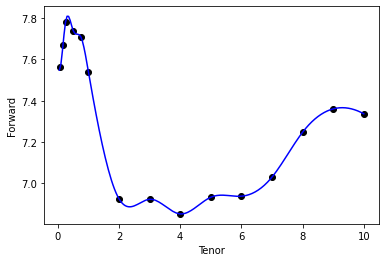

In [25]:
#Input data (fwds are in %):
fwd_curve = [(1/12,0.0756330723636039), (2/12,0.0766934654909107), (0.25,0.0778104050523594), (0.5,0.0773971156660421), (0.75,0.0770926233856078), (1,0.0753846086995074), (2,0.0692432887688875), (3,0.0692252943061663), (4,0.0685178882143826), (5,0.0693259640667515), (6,0.069375220644603), (7,0.0703013944220464), (8,0.0724733276066309), (9,0.0736041161904691), (10,0.0733657451797859)]
#Interpolation by cubic spline:
T = []
fwd_val = []
for i in fwd_curve:
    T.append(i[0])
    fwd_val.append(i[1]*100)
    
def fwd_curve_interp(fwd_curve, time):
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(T, fwd_val, k=3)
    fwd3 = spline3(time)
    return fwd3
fwd_curve_interp_values = []
for i in Tenors:
    fwd_curve_interp_values.append(fwd_curve_interp(fwd_curve, i))
#Plotting
plt.plot(Tenors, fwd_curve_interp_values, color = "blue")
plt.scatter(T, fwd_val, color = "black")
plt.xlabel('Tenor')
plt.ylabel('Forward')
plt.show()

## ATMF volatility interpolation

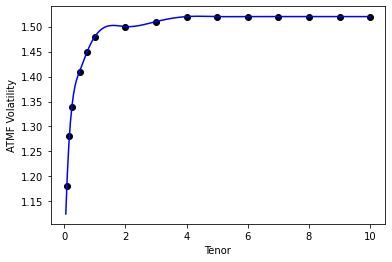

In [26]:
#Input (vols are in bps):
atmf_vols = [(1/12, 118), (2/12, 128), (0.25, 134), (0.50, 141), (0.75, 145), (1.00, 148), (2.00, 150), (3.00, 151), (4.00, 152),  (5.00, 152), (6.00, 152), (7.00, 152), (8.00, 152), (9.00, 152), (10.00, 152)]
#Interpolation by cubic spline:
T = []
vol_val = []
for i in atmf_vols:
    T.append(i[0])
    vol_val.append(i[1]/100)

def sigma_0_byT(atmf_vols, t):
    spline3 = scipy.interpolate.InterpolatedUnivariateSpline(T, vol_val, k=3)
    yn3 = spline3(t)
    return yn3

sigma_0_hat_values = []
for i in Tenors:
    sigma_0_hat_values.append(sigma_0_byT(atmf_vols, i))

plt.plot(Tenors, sigma_0_hat_values, color = "blue")
plt.scatter(T, vol_val, color = "black")
plt.xlabel('Tenor')
plt.ylabel('ATMF Volatility')
plt.show()

### SABR params

$\rho$ - corretion between $\sigma_{SABR}$ and Forwards ($\mathbb{E}\left[ dW_{1t} dW_{2t} \right]$)

$\beta$ - curvature of skew 

$\alpha$ - volatility of volatility (due to SABR is stochastic model, it leads to insuffucient curvature in short-end dates, so I recalibrate alpha to make it higher for short tenors)

In [27]:
rho = 0.7
beta = 0.8
alpha = 1.5
def alpha_better_skew(T, Tbench = 3, alpha0 = alpha):
    #alpha_res = alpha0*((Tbench/T)**0.5)
    alpha_res = alpha0
    return alpha_res

#### From $\href{http://web.math.ku.dk/~rolf/SABR.pdf}{Hagan \, and \, other \, (2002)}$: 

$$\sigma_{SABR}(\tau, K, F, alpha, rho, \widehat{\sigma_0}(T), beta)$$

In [28]:
def sigma_sabr(t, T, K, f, alpha, rho, sigma0, beta):
    tau = T - t
    #f = abs(f)
    fk = (f*K)**(1-beta)
    z = alpha / sigma0 * fk**0.5 * np.log(f/K)
    x=np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    if K == f:
        numerator = sigma0*(1+tau*( (1-beta)**2/24 * sigma0**2/(f**(2-2*beta)) + 1/4*rho*beta*alpha*sigma0/(f**(1-beta)) + (2-3*rho**2)/24*alpha**2) )
        denominator = f**(1-beta)
        sigma=numerator/denominator
    else:
        if alpha == 0:
            sigma = sigma0
        else:
            numerator = 1+tau*( (1-beta)**2/24 * sigma0**2/(fk) + 1/4*rho*beta*alpha*sigma0/(fk**0.5) + (2-3*rho**2)/24*alpha**2) 
            denominator = fk**0.5 * (1+(1-beta)**2/24*(np.log(f/K))**2 + (1-beta)**4/1920 * (np.log(f/K))**4)
            sigma=sigma0*(z/x)*numerator/denominator
    return sigma

## ATMF vols calibrattion: $\widehat{\sigma_0}(T)$

Here I want to find such $\widehat{\sigma_0}(T)$ that $\sigma_{SABR}(T,K = Forward)$ = ATMF Volatility Curve (is input) which is function of T

In [29]:
#Calibrate atmf vols: find sigma0 such as atmf(sabr) = atmf_vols
fwd = fwd_curve_interp_values
vol_y = list()
sigma_output = list()
for j in range(len(Tenors)):   
    vol_y.append(sigma_0_byT(atmf_vols, Tenors[j]))
    def func(s):
        return vol_y[j] - sigma_sabr(t=0,T=Tenors[j],K=fwd[j],f=fwd[j],alpha=alpha_better_skew(Tenors[j]),rho=rho,sigma0 = s,beta=beta)
    sigma_output.append(optimize.fsolve(func, vol_y[j]))

## SABR Surface { $\sigma_{SABR}(T,K)$| $\alpha(T), \beta, \rho$, ATMF vols and Forward curve }

Function is called $\mathbf{iv}(T,K)$

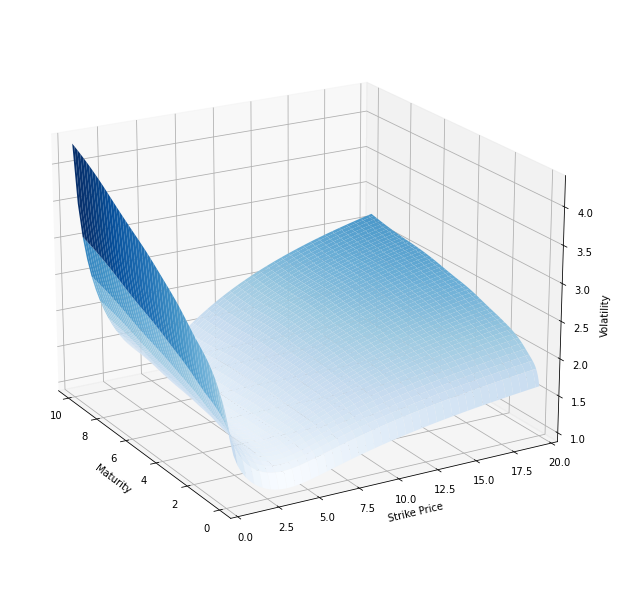

In [61]:
sigma_sabr_M = np.zeros((len(Tenors), len(Strikes)))

for j in range(len(Tenors)):
    for i in range(len(Strikes)):
        sigma_sabr_M[j][i] = sigma_sabr(t=0,T=Tenors[j],K=Strikes[i],f=fwd[j],alpha=alpha_better_skew(Tenors[j]),rho=rho,sigma0=sigma_output[j],beta=beta)
#SABR vol function
def iv(T,K):
    T = int((T - tstart)*(1/tstart))
    K = int((K - kstart)*(1/kstart))
    return sigma_sabr_M[T][K]
impliedvol=np.vectorize(iv)

Time, Ks = np.meshgrid(Tenors, Strikes)

Vol = impliedvol(Time, Ks)

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.plot_surface(Time, Ks, Vol, cmap = "Blues")
#ax.view_init(60,45)
plt.xlabel('Maturity')
plt.ylabel('Strike Price')
ax.set_zlabel('Volatility')
#plt.show()
ax.set_ylim(20,0)
ax.view_init(20, 150)
plt.show()

Particular term structures ($K = forwards+1.00 pp$ and $K = forwards+2.00 pp$)

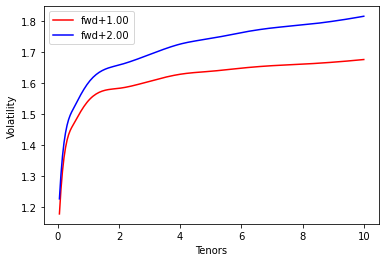

In [67]:
vols_T1 = []
vols_T2 = []
k = 0
for i in Tenors:
    #K=fwd_curve_interp_values[k]+2
    vols_T1.append(sigma_sabr(t=0,T=i,K=fwd_curve_interp_values[k]+1,f=fwd_curve_interp_values[k],alpha=alpha_better_skew(i),rho=rho,sigma0=sigma_output[k],beta=beta))
    vols_T2.append(sigma_sabr(t=0,T=i,K=fwd_curve_interp_values[k]+2,f=fwd_curve_interp_values[k],alpha=alpha_better_skew(i),rho=rho,sigma0=sigma_output[k],beta=beta))
    k+=1
plt.plot(Tenors, vols_T1, color = "red",label='fwd+1.00') + plt.plot(Tenors, vols_T2, color = "blue",label='fwd+2.00')
plt.xlabel('Tenors')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Particular skews ($T = 0.5$ and $T = 3$)

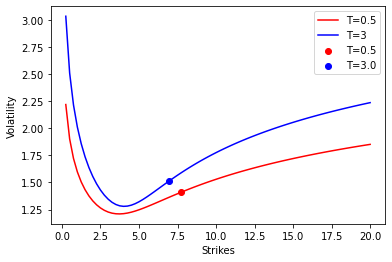

In [91]:
vols_smile1 = []
vols_smile2 = []
for i in Strikes:
    vols_smile1.append(sigma_sabr(t=0,T=0.5,K=i,f=fwd_curve_interp(fwd_curve, 0.5),alpha=alpha_better_skew(0.5),rho=rho,sigma0=sigma_output[np.where(Tenors == 0.5)[0][0]],beta=beta))
    vols_smile2.append(sigma_sabr(t=0,T=3,K=i,f=fwd_curve_interp(fwd_curve, 3),alpha=alpha_better_skew(3),rho=rho,sigma0=sigma_output[np.where(Tenors == 3)[0][0]],beta=beta))

plt.plot(Strikes, vols_smile1, color = "red",label='T=0.5') + plt.plot(Strikes, vols_smile2, color = "blue",label='T=3')
plt.scatter(fwd_curve_interp(fwd_curve, 0.5), sigma_0_byT(atmf_vols, 0.5), color = "red",label='T=0.5')
plt.scatter(fwd_curve_interp(fwd_curve, 3), sigma_0_byT(atmf_vols, 3.0), color = "blue",label='T=3.0')

plt.xlabel('Strikes')
plt.ylabel('Volatility')
plt.legend()
plt.show()